In [1]:
import pandas as pd
import dill

import numpy as np
import sympy as sym
import os
import thermoengine

import pyximport
import importlib
sym.init_printing()


# Import DEW 2019 Aqueous Species

**To do:**
- Change the code to use a more obvious folder name than 'working'

This notebook runs the code required to generate a database from a set of DEW parameters.

Aaron Wolf wrote functions that make this process easier to implement, originally for use in his carbonated mantle demonstration. The following line runs this file, therefore defining the functions written within it.

In [2]:
def make_custom_database(mod_name, phase_params, 
                         working_dir='working',calib=False):
    
    modelDB = None
    coder_mod = None
    
    model.set_module_name(mod_name)
    !mkdir -p {working_dir}
    %cd {working_dir}
    
    try:
        phase_info = {}
        
        sources_list = ''
        os.system('rm '+mod_name+'.pyx')
        
        phase_key = pd.Series()
        
        for phs in phase_params:
            param_dict = phase_params[phs]
            phs_nm = param_dict['Phase']
            phase_info[phs] = [phs_nm, 'pure']
            phase_key[phs] = phs_nm
            
            sources_list = _add_model_phase(
                param_dict, mod_name, sources_list=sources_list,calib=calib)
            
        pyxbld_filenm = mod_name+'.pyxbld'
        _rewrite_pyxbld_sources(pyxbld_filenm, sources_list)
        
        
        phase_tuple =  (mod_name, phase_info)
        
        coder_mod = importlib.import_module(mod_name)
        
        
        modelDB = thermoengine.model.Database(
            database='CoderModule', phase_tuple=phase_tuple,calib=calib)
    except:
        print('There is something wrong with this custom database attempt')
        raise
    
    %cd ..
    return modelDB, coder_mod, phase_key

def _add_model_phase(param_dict, mod_name, sources_list=None, 
                    calib=False):
    filenm = mod_name+'.pyx'
    tmpnm = 'tmpfile.pyx'
    tmpnm2 = 'tmpfile2.pyx'
    
    os.system('touch '+ filenm)
    os.system('mv '+filenm+' '+tmpnm)
    
    
    phase_name = param_dict.pop('Phase', None)
    formula = param_dict.pop('Formula', None)
    if calib == True:
        module_type = 'calib'
    else:
        module_type = 'fast'
    result = model.create_code_module(phase=phase_name, formula=formula, 
                                      params=param_dict, module_type=module_type)
    
    os.system('cat '+filenm+' '+tmpnm+' > '+tmpnm2)
    os.system('mv '+tmpnm2 + ' ' + filenm)
    os.system('rm '+tmpnm)
    os.system('rm '+tmpnm2)
    
    
    if sources_list is None:
        sources_list = ''
        
    if calib == True:
        source_file = phase_name+'_'+mod_name+'_calib.c'
    else:
        source_file = phase_name+'_'+mod_name+'_calc.c'
    sources_list += "'"+source_file + "', "
    
    return sources_list


def _rewrite_pyxbld_sources(filename, sources_list):
    with open(filename,'r') as file:
        lines = file.readlines()
        for ind, line in enumerate(lines):
            is_source_line = line.strip().startswith('sources')
            if is_source_line:
                ind_source = ind
            
        file.close()
        
        
    sources_update = ('                     sources=[pyxfilename, '+
                      sources_list[:-2] + '],\r\n')
    
    lines[ind_source] = sources_update
    
    with open(filename,'w') as file:
        file.writelines( lines )
        

Import the coder module and retrieve sympy extensions for the Born functions and for the Shock et al., (1992) "*g*" function:

In [3]:
from thermoengine import coder
from thermoengine.coder import B, Q, Y, U, N, X, dUdT, dUdP, dNdT, dNdP, dXdT, gSolvent

Create a standard state model instance ...

In [4]:
model = coder.StdStateModel()

... and retrieve sympy symbols for standard variables.

In [5]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
Tr = model.get_symbol_for_tr()
Pr = model.get_symbol_for_pr()

## Equation of State (EOS)
Shock et al., 1992, eqn. B10:   

${\bar v^o} = {a_1} + \frac{{{a_2}}}{{\Psi  + P}} + \left( {{a_3} + \frac{{{a_4}}}{{\Psi  + P}}} \right)\frac{1}{{T - \theta }} - \omega Q - \left( {B + 1} \right){\left( {\frac{{\partial \omega }}{{\partial P}}} \right)_T}$  

$\Psi$ has a value of 2600 bars as determined by Tanger and Helgeson (1988)  
$\theta$ has a value of 228 K as determined by Helgeson and Kirkham (1976)  

$\omega$ is defined in terms of the charge on the ion (*z*) and a mysterious function, *g*, as derived by Shock et al. (1992),building on the work of Tanger and Helgeson (1988):  

$\omega  = \eta z\left( {\frac{z}{{{r_{e,ref}} + \left| z \right|g}} - \frac{1}{{{r_{e,{H^ + }}} + g}}} \right)$  

where $\eta$ is a conversion constant.  The reference ionic radius is:

${r_{e,ref}} = \frac{{{z^2}}}{{\frac{{{\omega _{ref}}}}{\eta } + \frac{z}{{{r_{e,{H^ + }}}}}}}$   

which when inserted into the definition becomes  

$\omega  = \left( {\frac{{{\omega _{ref}} + \frac{{z\eta }}{{{r_{e,{H^ + }}}}}}}{{1 + \frac{{\sqrt {{z^2}} }}{{{z^2}}}g\left( {\frac{{{\omega _{ref}}}}{\eta } + \frac{z}{{{r_{e,{H^ + }}}}}} \right)}} - \frac{{\eta z}}{{{r_{e,{H^ + }}} + g}}} \right)$  

The above expression is cast into a slightly different form than the one provided by Shock et al. (1992), but is otherwise identical. This form is applicable to both charged and neutral species, as demonstrated below.

In [6]:
eta, rH, omega0, z = sym.symbols('eta rH omega0 z', real=True)

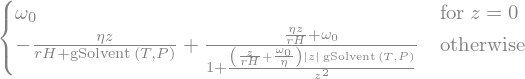

In [7]:
omega_def = sym.Piecewise((omega0, sym.Eq(z,0)), \
            ((omega0 + z*eta/rH)/(1 + sym.Abs(z)*gSolvent(T,P)*(omega0/eta + z/rH)/z**2) - eta*z/(rH + gSolvent(T,P)), True))
omega_def

Hence, ${\bar v^o} = {a_1} + \frac{{{a_2}}}{{\Psi  + P}} + \left( {{a_3} + \frac{{{a_4}}}{{\Psi  + P}}} \right)\frac{1}{{T - \theta }} - \omega Q - \left( {B + 1} \right){\left( {\frac{{\partial \omega }}{{\partial P}}} \right)_T}$ is

In [8]:
a1,a2,a3,a4 = sym.symbols('a1 a2 a3 a4')
Psi,theta = sym.symbols('Psi theta')
omega = sym.Function('omega')(T,P)

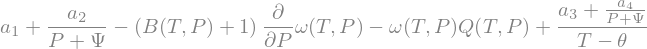

In [9]:
vtp = a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta) - omega*Q(T,P) - (B(T,P)+1)*omega.diff(P)
vtp

Note that the derivative of $ - \left[ {\left( {{B_{T,P}} + 1} \right){\omega _{T,P}} - \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}}} \right]$

In [10]:
-(1+B(T,P))*omega + (1+B(T,Pr))*(omega.subs(P,Pr))

is

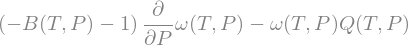

In [11]:
(-(1+B(T,P))*omega + (1+B(T,Pr))*(omega.subs(P,Pr))).diff(P)

So that $\int_{{P_r}}^P {{{\bar v}^o}} dP$ may be written:

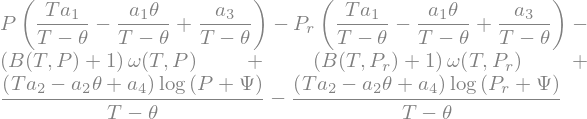

In [12]:
deltaG = sym.integrate(a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta), (P,Pr,P)) - (1+B(T,P))*omega + (1+B(T,Pr))*omega.subs(P,Pr)
deltaG

The second derivative of this volume integral gives the contribution to the heat capacity, i.e. $\frac{{{\partial ^2}G}}{{\partial {T^2}}} =  - \frac{{\partial S}}{{\partial T}} =  - \frac{{{C_P}}}{T}$ so that  

${{\bar c}_P}\left( {T,P} \right) - {{\bar c}_P}\left( {T,{P_r}} \right) =  - T\frac{{{\partial ^2}\int_{{P_r}}^P {{{\bar v}^o}} dP}}{{\partial {T^2}}}$

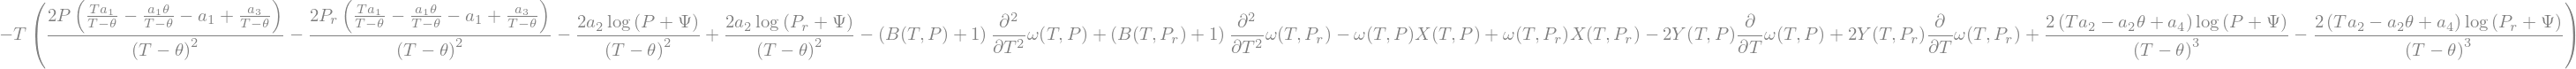

In [13]:
-T*deltaG.diff(T,2)

## Heat Capacity functions
Heat capacity is parameterized as (Tanger and Helgeson, 1988, eq A-4, p 78):

${{\bar c}_P} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} - \left[ {\frac{{2T}}{{{{\left( {T - \theta } \right)}^3}}}} \right]\left[ {{a_3}\left( {P - {P_r}} \right) + {a_4}\ln \left( {\frac{{\Psi  + P}}{{\Psi  + {P_r}}}} \right)} \right] + \omega TX + 2TY\frac{{\partial \omega }}{{\partial T}} - T\left( {\frac{1}{\varepsilon } - 1} \right)\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}$  

or equivalently, as the Born function is defined as $B =  - \frac{1}{\varepsilon }$  

${{\bar c}_P} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} - \left[ {\frac{{2T}}{{{{\left( {T - \theta } \right)}^3}}}} \right]\left[ {{a_3}\left( {P - {P_r}} \right) + {a_4}\ln \left( {\frac{{\Psi  + P}}{{\Psi  + {P_r}}}} \right)} \right] + \omega TX + 2TY\frac{{\partial \omega }}{{\partial T}} + T\left( {B + 1} \right)\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}$  

at the reference pressure this expression becomes  

${\bar c_{{P_r}}} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + {\omega _{{P_r}}}T{X_{T,{P_r}}} + 2T{Y_{T,{P_r}}}{\left. {\frac{{\partial \omega }}{{\partial T}}} \right|_{T,{P_r}}} + T\left( {{B_{T,{P_r}}} + 1} \right){\left. {\frac{{{\partial ^2}\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$  

Note that the "Born" function terms are the equivalent of $T{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$, so that the reference pressure heat capacity can be equivalently written:  

${{\bar c}_{{P_r}}} = {c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + T{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|_{T,{P_r}}}$

as demonstrated here:

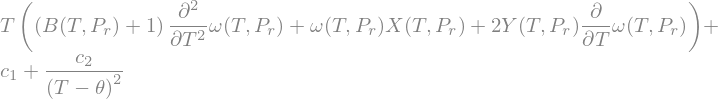

In [14]:
c1,c2 = sym.symbols('c1 c2')
ctpr = c1 + c2/(T-theta)**2 + (T*((B(T,P)+1)*omega).diff(T,2)).subs(P,Pr)
ctpr

## Gibbs free energy
The above analysis gives a way to write the Gibbs free energy using the identity $dG =  - SdT + VdP$, from which:  

${G_{T,P}} = {G_{{T_r},{P_r}}} - \int_{{T_r}}^T {{S_{T,{P_r}}}dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

The entropy term is given by  

${S_{T,{P_r}}} = {S_{{T_r},{P_r}}} + \int_{{T_r}}^T {\frac{{{{\bar c}_{T,{P_r}}}}}{T}dT}$  

Combining expressions  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\frac{{{{\bar c}_{T,{P_r}}}}}{T}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

Now, using the above expression for the reference pressure heat capacity we can write  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\frac{{\left( {{c_1} + \frac{{{c_2}}}{{{{\left( {T - \theta } \right)}^2}}} + T{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}} \right)}}{T}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

or  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\left[ {\frac{{{c_1}}}{T} + \frac{{{c_2}}}{{T{{\left( {T - \theta } \right)}^2}}} + {{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}} \right]dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

which expands to  

${G_{T,P}} = {G_{{T_r},{P_r}}} - {S_{{T_r},{P_r}}}\left( {T - {T_r}} \right) - \int_{{T_r}}^T {\int_{{T_r}}^T {\left[ {\frac{{{c_1}}}{T} + \frac{{{c_2}}}{{T{{\left( {T - \theta } \right)}^2}}}} \right]dT} dT}  - \int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  + \int_{{P_r}}^P {{V_{T,P}}dP}$  

Note that $\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}$ evaluates to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \int_{{T_r}}^T {\left[ {{{\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|}_{T,{P_r}}} - {{\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|}_{{T_r},{P_r}}}} \right]dT}$  

and further to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,P_r}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {\left. {\frac{{\partial \left( {B + 1} \right)\omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}\left( {T - {T_r}} \right)$  

and still further to:  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {\left. {\frac{{\partial B}}{{\partial T}}} \right|_{{T_r},{P_r}}}{\omega _{{T_r},{P_r}}}\left( {T - {T_r}} \right) - {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}\left( {T - {T_r}} \right)$  

recognizing that $Y = \frac{{\partial B}}{{\partial T}}$, we have finally  

$\int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  = \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} - \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} - {Y_{{T_r},{P_r}}}\left( {T - {T_r}} \right){\omega _{{T_r},{P_r}}} - {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\left( {T - {T_r}} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}$  

Note that:  

$ - \int_{{T_r}}^T {\int_{{T_r}}^T {{{\left. {\frac{{{\partial ^2}\left( {B + 1} \right)\omega }}{{\partial {T^2}}}} \right|}_{T,{P_r}}}dT} dT}  =  - \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}} + \left( {{B_{{T_r},{P_r}}} + 1} \right){\omega _{{T_r},{P_r}}} + {Y_{{T_r},{P_r}}}\left( {T - {T_r}} \right){\omega _{{T_r},{P_r}}} + {\left. {\left( {{B_{{T_r},{P_r}}} + 1} \right)\left( {T - {T_r}} \right)\frac{{\partial \omega }}{{\partial T}}} \right|_{{T_r},{P_r}}}$  

and

$\int_{{P_r}}^P {{V_{T,P}}dP}  = f\left( {T,\theta ,{a_1},{a_2},{a_3},{a_4},T,P,{P_r}} \right) - \left( {{B_{T,P}} + 1} \right){\omega _{T,P}} + \left( {{B_{T,{P_r}}} + 1} \right){\omega _{T,{P_r}}}$

Add to the above parameters the reference state enthalpy, $H_{ref}$ and the reference state entropy, $S_{ref}$

In [15]:
Gref,Sref = sym.symbols('G_ref S_ref')

##  Derive an expression for the Gibbs free energy

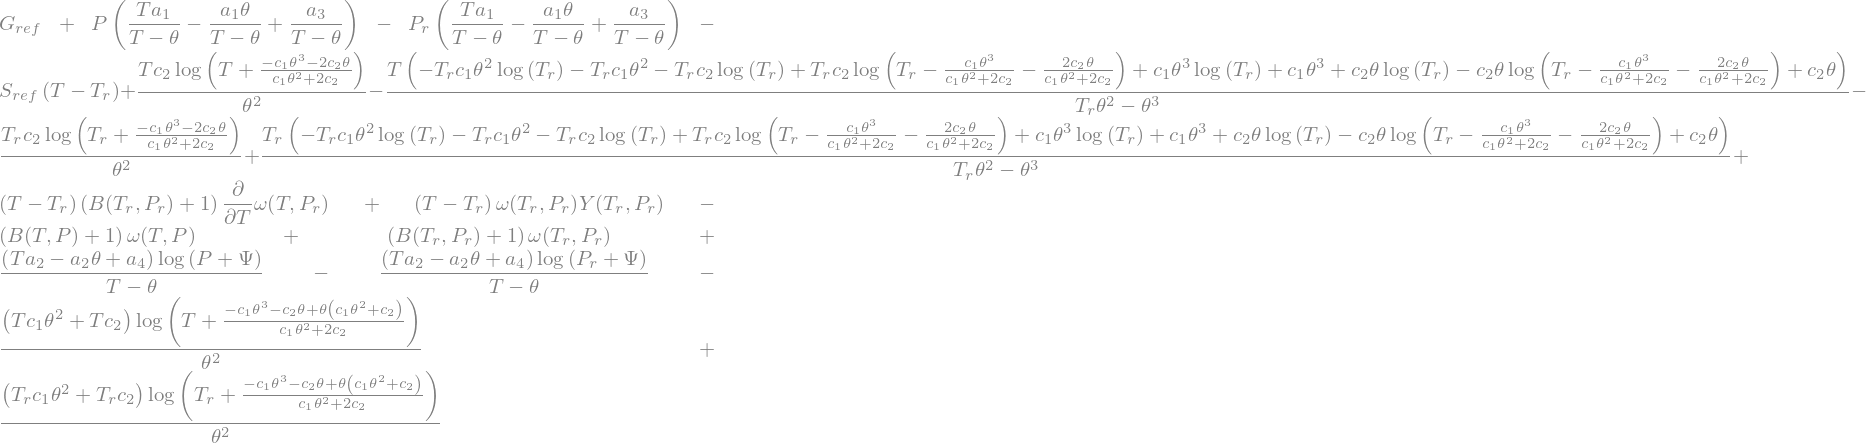

In [16]:
gtp = Gref - Sref*(T-Tr) - sym.integrate(sym.integrate((c1 + c2/(T-theta)**2)/T, (T,Tr,T)), (T,Tr,T)) \
    - (B(T,Pr)+1)*omega.subs(P,Pr) + (B(Tr,Pr)+1)*omega.subs(P,Pr).subs(T,Tr) \
    + Y(Tr,Pr)*(T-Tr)*omega.subs(P,Pr).subs(T,Tr) + (B(Tr,Pr)+1)*(T-Tr)*omega.diff(T).subs(P,Pr) \
    + sym.integrate(a1 + a2/(Psi+P) + (a3 + a4/(Psi+P))/(T-theta), (P,Pr,P)) - (1+B(T,P))*omega + (1+B(T,Pr))*omega.subs(P,Pr)
gtp

At the reference pressure, $\omega$ is a constant, $\omega_0$, and its derivatives are zero too.

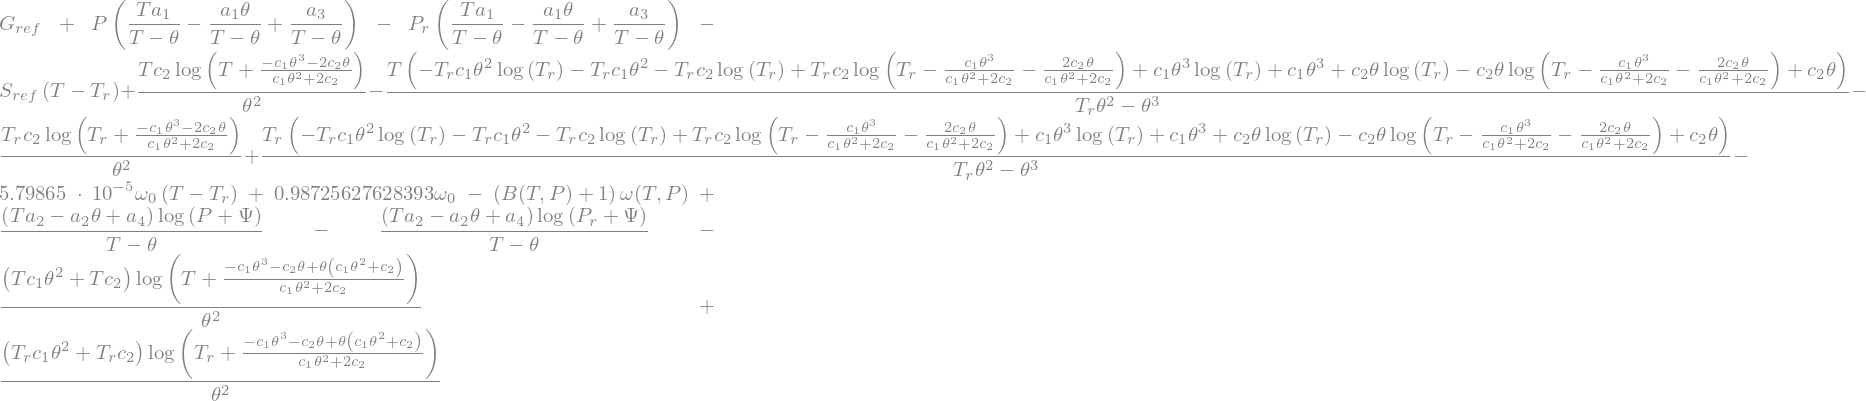

In [17]:
gtp = gtp.subs(omega.subs(T,Tr).subs(P,Pr), omega0)
gtp = gtp.subs(omega.diff(T).subs(P,Pr),0)
gtp = gtp.subs(Y(Tr,Pr),-5.79865E-05)
gtp = gtp.subs(B(Tr,Pr),-1/78.47)
gtp

Substitute the definition of the omega function into the expression for the Gibbs free energy

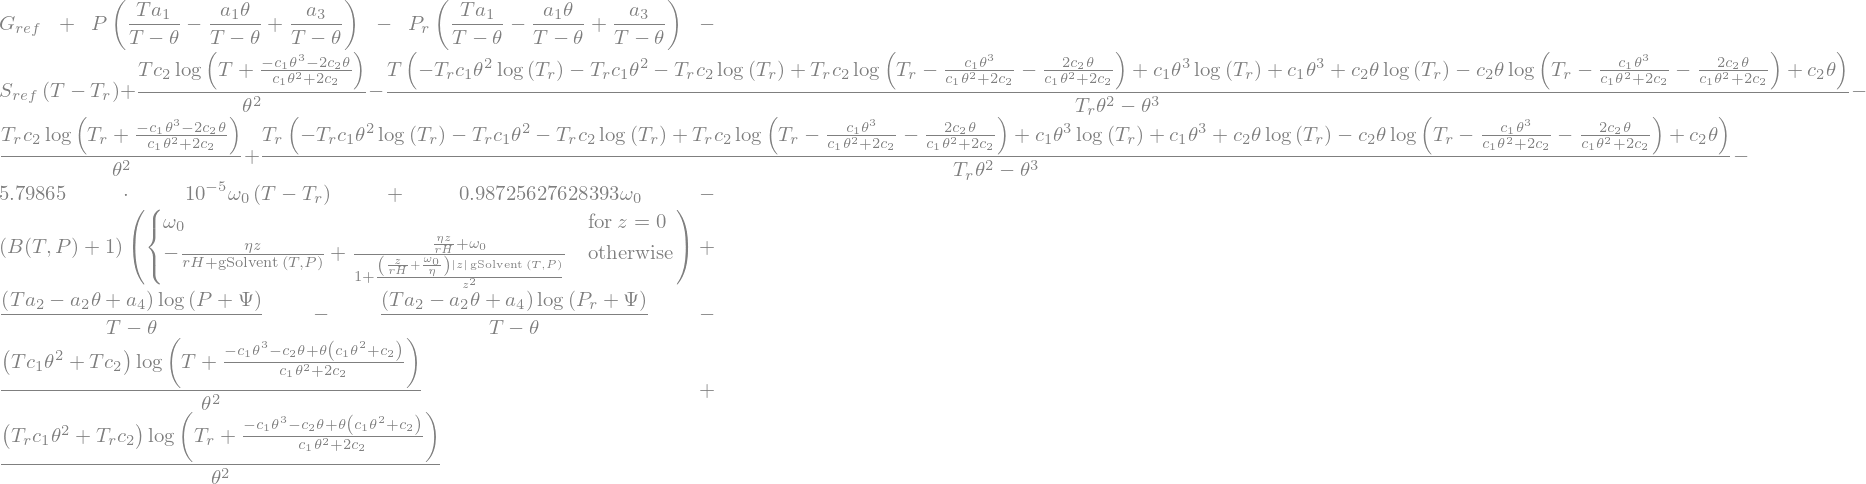

In [18]:
gtp = gtp.subs(omega,omega_def)
gtp

The "charge" contribution to the Gibbs free energy is 

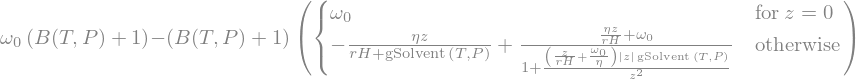

In [19]:
gtp-gtp.subs(z,0)

Add the derived expression for *G(T,P)* and its parameter list to the model

In [20]:
params = [('G_ref','J',Gref), ('S_ref','J/K',Sref), 
          ('a1','J/bar-m',a1), ('a2','J/bar^2-m',a2), ('a3','J/bar-m',a3),  ('a4','J/bar^2-m',a4), 
          ('c1','J/K-m',c1), ('c2','J-K/m',c2), 
          ('Psi', 'bar', Psi), ('eta', 'Å-J/mole', eta), ('rH', 'Å', rH), ('omega0','J',omega0), 
          ('theta','K',theta), ('z', '', z)]
model.add_expression_to_model(gtp, params)

## Code Print the Model, compile the code and link a Python module
Name the model class

In [21]:
# model.set_module_name('hkf')
model.set_include_born_code(True)

## Import and process the DEW database

I have extracted the aqueous species parameters from the DEW "Aqueous Species Options" worksheet. I renamed some of the complexes so that conventions are applied more consistently. I added a column expressing the formulae in the format require by ENKI. For complexes where their parameters are estimated, this estimation must be done by the coder module, I do not import the DEW spreadsheet calculated estimates.

In [22]:
dew = pd.read_csv('dew2019_cleaned.csv')
dew = dew.fillna(0)
dew

,name,EQ_name,symbol,formula,include,G_ref,H_ref,S_ref,V_ref,Cp_ref,...,prd_ac,compl,gas,a1,a2,a3,a4,c1,c2,comments
0,acetate-,CH3COO-,CH3COO-,C(2)H(3)O(2),1,-88270,-116180.0,20.60,40.499926,6.311743,...,0,0,0,10.018000,2.809000,6.720000,-2.894100,26.300000,-3.860000,"revised January 26th, 2016; new a1 value from ..."
1,"acetic-acid,aq",CH3COOH(AQ),CH3COOH,C(2)H(4)O(2),1,-94760,-116100.0,42.70,52.010022,41.083552,...,0,0,0,11.500000,5.500000,1.670000,-2.870000,44.900000,-2.630000,Plyasunov & Shock (2001)
2,Ag+,AG+,Ag(+),Ag(1),1,18427,25275.0,17.54,-0.800078,7.899675,...,1,0,0,2.046420,-4.387714,7.018169,-2.597612,12.786274,-1.425436,Shock & Helgeson (1988) revised with new predi...
3,"AgCl,aq",AGCL(AQ),AgCl(0),Ag(1)Cl(1),0,-17450,-18270.0,34.10,27.000000,6.700094,...,1,1,0,6.745843,2.139576,3.044087,-2.867450,9.743185,-1.669791,Sverjensky et al. (1997) with new V greater th...
4,AgCl2-,AGCL2-,AgCl2(-),Ag(1)Cl(2),0,-51560,-61130.0,47.00,53.000000,7.699896,...,1,1,0,12.253325,7.383245,-1.352680,-3.084223,19.126467,-1.466131,Sverjensky et al. (1997) with new V greater th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Zn+2,ZN+2,Zn(+2),Zn(1),1,-35200,-36660.0,-26.20,-24.300094,-6.300282,...,1,0,0,-1.417424,-9.478710,9.977699,-2.387150,15.901037,-4.317967,Shock & Helgeson (1988) revised with new predi...
225,ZnCl+,ZNCL+,ZnCl(+),Zn(1)Cl(1),0,-66850,-66240.0,23.00,4.800000,19.899909,...,1,1,0,2.549738,-1.855533,6.393947,-2.702292,19.694777,1.019011,Sverjensky et al. (1997) with revised a1 equal...
226,"ZnCl2,aq",ZNCL2(AQ),ZnCl2(0),Zn(1)Cl(2),0,-98300,-109080.0,27.03,26.000000,34.660101,...,1,1,0,6.551633,1.954668,3.199130,-2.859806,26.129473,4.025663,Sverjensky et al. (1997) with revised a1 equal...
227,ZnCl3-,ZNCL3-,ZnCl3(-),Zn(1)Cl(3),0,-129310,-151060.0,25.00,43.900000,41.970000,...,1,1,0,10.646411,5.853303,-0.069838,-3.020976,42.291632,5.514689,Sverjensky et al. (1997) with revised a1 equal...


The parameters given in the DEW spreadsheet are multiplied by factors of 10 for easier display, and the units of energy are colories not Joules. This can be fixed here:

In [23]:
multipliers = {'a1': 4.184/10,
               'a2': 4.184*100,
               'a3': 4.184,
               'a4': 4.184*1e4,
               'c1': 4.184,
               'c2': 4.184*1e4,
               'G_ref': 4.184,
               'H_ref': 4.184,
               'S_ref': 4.184,
               'V_ref': 0.1,
               'Cp_ref': 4.184,
               'omega0': 4.184*1e5}

for col in list(multipliers.keys()):
    dew[col] = dew[col] * multipliers[col]

dew

,name,EQ_name,symbol,formula,include,G_ref,H_ref,S_ref,V_ref,Cp_ref,...,prd_ac,compl,gas,a1,a2,a3,a4,c1,c2,comments
0,acetate-,CH3COO-,CH3COO-,C(2)H(3)O(2),1,-369321.680,-486097.12,86.19040,4.049993,26.408331,...,0,0,0,4.191531,1175.285600,28.116480,-121089.144000,110.039200,-161502.400000,"revised January 26th, 2016; new a1 value from ..."
1,"acetic-acid,aq",CH3COOH(AQ),CH3COOH,C(2)H(4)O(2),1,-396475.840,-485762.40,178.65680,5.201002,171.893580,...,0,0,0,4.811600,2301.200000,6.987280,-120080.800000,187.861600,-110039.200000,Plyasunov & Shock (2001)
2,Ag+,AG+,Ag(+),Ag(1),1,77098.568,105750.60,73.38736,-0.080008,33.052241,...,1,0,0,0.856222,-1835.819346,29.364018,-108684.082816,53.497768,-59640.249478,Shock & Helgeson (1988) revised with new predi...
3,"AgCl,aq",AGCL(AQ),AgCl(0),Ag(1)Cl(1),0,-73010.800,-76441.68,142.67440,2.700000,28.033192,...,1,1,0,2.822461,895.198426,12.736460,-119974.110301,40.765485,-69864.051884,Sverjensky et al. (1997) with new V greater th...
4,AgCl2-,AGCL2-,AgCl2(-),Ag(1)Cl(2),0,-215727.040,-255767.92,196.64800,5.300000,32.216365,...,1,1,0,5.126791,3089.149764,-5.659614,-129043.905131,80.025136,-61342.929492,Sverjensky et al. (1997) with new V greater th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Zn+2,ZN+2,Zn(+2),Zn(1),1,-147276.800,-153385.44,-109.62080,-2.430009,-26.360379,...,1,0,0,-0.593050,-3965.892286,41.746694,-99878.361272,66.529939,-180663.755263,Shock & Helgeson (1988) revised with new predi...
225,ZnCl+,ZNCL+,ZnCl(+),Zn(1)Cl(1),0,-279700.400,-277148.16,96.23200,0.480000,83.261218,...,1,1,0,1.066810,-776.354860,26.752275,-113063.908995,82.402946,42635.437729,Sverjensky et al. (1997) with revised a1 equal...
226,"ZnCl2,aq",ZNCL2(AQ),ZnCl2(0),Zn(1)Cl(2),0,-411287.200,-456390.72,113.09352,2.600000,145.017864,...,1,1,0,2.741203,817.833260,13.385159,-119654.282705,109.325714,168433.725945,Sverjensky et al. (1997) with revised a1 equal...
227,ZnCl3-,ZNCL3-,ZnCl3(-),Zn(1)Cl(3),0,-541033.040,-632035.04,104.60000,4.390000,175.602480,...,1,1,0,4.454458,2449.022051,-0.292204,-126397.617138,176.948188,230734.587760,Sverjensky et al. (1997) with revised a1 equal...


Create a function to generate the parameter dictionary required for each phase by the coder module. Create a name for the species that can be used in filenames.

In [24]:
def HKF_params(species='H+',Formula='', z=0.0,
                   G_ref=0.0, S_ref=0.0, V_ref=0.0, Cp_ref = 0.0,
                   a1=0.0, a2=0.0, a3=0.0, a4=0.0,
                   c1=0.0, c2=0.0, omega0=0.0,
                   theta=228.0, Psi=2600.0, eta=694657.0, rH=3.082,
                   T_r=298.15, P_r=1.0):
    
    species_name = species
    
    if species_name[-1] == '-':
        species_name = species_name[:-1]+'_n'
    if species_name[-2] == '-':
        species_name = species_name[:-2]+'_n'+species_name[-1]
    species_name = species_name.replace('-','_')
    species_name = species_name.replace('+','_p')
    species_name = species_name.replace('(','_l_')
    species_name = species_name.replace(')','_r_')
        
    species_name = species_name.replace(',','_')
    
    param_dict = {'Phase': species_name,
                  'Formula': Formula,
                  'G_ref':G_ref,
                  'S_ref':S_ref,
                  'v_ref':V_ref,
                  'C_p_ref':Cp_ref,
                  'a1':a1,
                  'a2':a2,
                  'a3':a3,
                  'a4':a4,
                  'c1':c1,
                  'c2':c2,
                  'omega0':omega0,
                  'theta':theta,
                  'Psi':Psi,
                  'eta':eta,
                  'rH':rH,
                  'z':z,
                  'T_r':T_r,
                  'P_r':P_r}
    return param_dict

## Create objects for each DEW species
First, create a dictionary of phase parameters for each species

**NOTE: To use the 'prettier' complex names that are not entirely capitalised, change row['EQ_name'] to row['name']**. Capitalised names ensure compatibility with all versions of EQ3 and EQ6.

In [25]:
phase_params = {}
for i, row in dew.iterrows():
    phase_params[row['EQ_name']] = HKF_params(species=row['EQ_name'],Formula=row['formula'], z=row['z'],
                   G_ref=row['G_ref'], S_ref=row['S_ref'], V_ref=row['V_ref'], Cp_ref = row['Cp_ref'],
                   a1=row['a1'], a2=row['a2'], a3=row['a3'], a4=row['a4'],
                   c1=row['c1'], c2=row['c2'], omega0=row['omega0'])

Build the database, including generating the coder files

In [26]:
mod_name = 'dew2019'
modelDB, codermod, phase_key = make_custom_database(mod_name,phase_params,working_dir='../pyDEW/dew2019_coderfiles')

/Users/simonmatthews/repos/pyDEW/pyDEW/dew2019_coderfiles
Creating (once only) generic fast model code file string


/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Creating (once only) generic model fast code template include file string
Creating (once only) generic model fast code template code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
wri

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to work

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to work

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: 

writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to worki

No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to work

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dew2019


rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/simonmatthews/repos/pyDEW/pyDEW/dew2019_coderfiles/dew2019.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /Users/simonmatthews/.pyxbld/temp.macosx-10.9-x86_64-3.7/pyrex/dew2019.c:698:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/nump

/Users/simonmatthews/repos/pyDEW/pyDEW


## Check database
I'm not sure putting all the species into a database is the right thing to do since they're not individual phases. Consider this later once the necessary functionality has been identified.

In [27]:
modelDB.phase_info

,abbrev,phase_name,formula,phase_type,endmember_num


## Save output phases

In [28]:
output = {}
for phsnm in phase_params:
    iphs = modelDB.get_phase(phsnm)
    output[phsnm] = iphs
output

{'CH3COO-': <thermoengine.phases.PurePhase at 0x7f96df59a650>,
 'CH3COOH(AQ)': <thermoengine.phases.PurePhase at 0x7f96de44fa10>,
 'AG+': <thermoengine.phases.PurePhase at 0x7f96df565f50>,
 'AGCL(AQ)': <thermoengine.phases.PurePhase at 0x7f96df464850>,
 'AGCL2-': <thermoengine.phases.PurePhase at 0x7f96df5a9190>,
 'AL+3': <thermoengine.phases.PurePhase at 0x7f96c0704610>,
 'AL(OH)4-': <thermoengine.phases.PurePhase at 0x7f96c024d690>,
 'AL(OH)SI(OH)-': <thermoengine.phases.PurePhase at 0x7f96de422350>,
 'AR(AQ)': <thermoengine.phases.PurePhase at 0x7f96c5ee9490>,
 'AU+': <thermoengine.phases.PurePhase at 0x7f96c5eeb150>,
 'AU+3': <thermoengine.phases.PurePhase at 0x7f96c023dad0>,
 'B(OH)3(AQ)': <thermoengine.phases.PurePhase at 0x7f96c0704110>,
 'BA+2': <thermoengine.phases.PurePhase at 0x7f96c0704290>,
 'BACL+': <thermoengine.phases.PurePhase at 0x7f96c0704190>,
 'BE+2': <thermoengine.phases.PurePhase at 0x7f96d81eec10>,
 'BENZENE(AQ)': <thermoengine.phases.PurePhase at 0x7f96b55c7250

In [29]:
with open('DEW2019.pkl','wb') as file:
    dill.dump(output, file)
    file.close()